---

# Insider Threat Detection Using Machine Learning  

This notebook demonstrates an **end-to-end ML pipeline** for detecting insider threats, covering:  
- **Traditional ML and Deep Learning models** to compare performance.  
- **MLflow integration** for model tracking, comparison, and deployment.  
- Two sections: one without MLflow (basic pipeline) and one with MLflow (enhanced traceability).  

The goal is to build a scalable, reproducible, and effective solution for identifying malicious or risky activities.
You will also find a .py version with docker files for future deployment

---

In [ ]:
# Import necessary libraries
!pip install numpy ngrok pandas mlflow scikit-learn tensorflow matplotlib seaborn pyngrok


In [11]:
import numpy as np
import pandas as pd
import mlflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns



In [12]:
# Enable GPU support
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.optimizer.set_jit(True)  # Enable XLA optimization
strategy = tf.distribute.MirroredStrategy() if len(tf.config.list_physical_devices('GPU')) > 0 else tf.distribute.get_strategy()

Num GPUs Available:  1


In [13]:
# Download and prepare dataset
import kagglehub
import os
import shutil

path = kagglehub.dataset_download("nitishabharathi/cert-insider-threat")
if not os.path.exists('/content/cert-insider-threat'):
    os.makedirs('/content/cert-insider-threat')
for file_name in os.listdir(path):
    shutil.move(os.path.join(path, file_name),
                os.path.join('/content/cert-insider-threat', file_name))

In [14]:
# Load and preprocess data with memory optimization
data = pd.read_csv('/content/cert-insider-threat/email.csv')
data_sample = data.sample(frac=0.1, random_state=42)
del data  # Free memory

In [15]:
# Basic preprocessing
data_sample['date'] = pd.to_datetime(data_sample['date'])
data_sample['cc'] = data_sample['cc'].fillna('')
data_sample['bcc'] = data_sample['bcc'].fillna('')

# Feature engineering
data_sample['num_recipients'] = (data_sample['to'].str.count(';') +
                               data_sample['cc'].str.count(';') +
                               data_sample['bcc'].str.count(';') + 1)
data_sample['hour'] = data_sample['date'].dt.hour
data_sample['day_of_week'] = data_sample['date'].dt.dayofweek
data_sample['is_weekend'] = data_sample['day_of_week'].isin([5, 6]).astype(int)
data_sample['is_night'] = ((data_sample['hour'] < 6) | (data_sample['hour'] > 22)).astype(int)

# TF-IDF with memory optimization
tfidf = TfidfVectorizer(max_features=100, stop_words='english')  # Reduced features
content_tfidf = tfidf.fit_transform(data_sample['content']).toarray()
content_tfidf_df = pd.DataFrame(content_tfidf, columns=tfidf.get_feature_names_out())
del content_tfidf  # Free memory

In [16]:
# Combine features
features = ['size', 'attachments', 'num_recipients', 'hour', 'day_of_week',
           'is_weekend', 'is_night']
X_numeric = data_sample[features]
X = pd.concat([X_numeric.reset_index(drop=True),
              content_tfidf_df.reset_index(drop=True)], axis=1)
del content_tfidf_df, X_numeric  # Free memory

In [17]:
# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
del X  # Free memory

In [18]:
# Generate labels
iso_forest = IsolationForest(contamination=0.01, random_state=42)
labels = iso_forest.fit_predict(X_scaled)
y = pd.Series(labels).map({1: 0, -1: 1})
del labels  # Free memory

In [19]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
del X_scaled, y  # Free memory


Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52070
           1       0.80      0.83      0.82       530

    accuracy                           1.00     52600
   macro avg       0.90      0.91      0.91     52600
weighted avg       1.00      1.00      1.00     52600



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9179 - loss: 0.2141 - val_accuracy: 0.9944 - val_loss: 0.0124
Epoch 2/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9950 - loss: 0.0114 - val_accuracy: 0.9948 - val_loss: 0.0104
Epoch 3/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9955 - loss: 0.0099 - val_accuracy: 0.9956 - val_loss: 0.0091
Epoch 4/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9961 - loss: 0.0089 - val_accuracy: 0.9958 - val_loss: 0.0086
Epoch 5/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9965 - loss: 0.0078 - val_accuracy: 0.9958 - val_loss: 0.0088
Epoch 6/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9965 - loss: 0.0077 - val_accuracy: 0.9964 - val_loss: 0.0076
Epoch 7/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9968 - loss: 0.0072 - val_accuracy: 0.9960 - val_loss: 0.0083
Epoch 8/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9971 - loss: 0.00

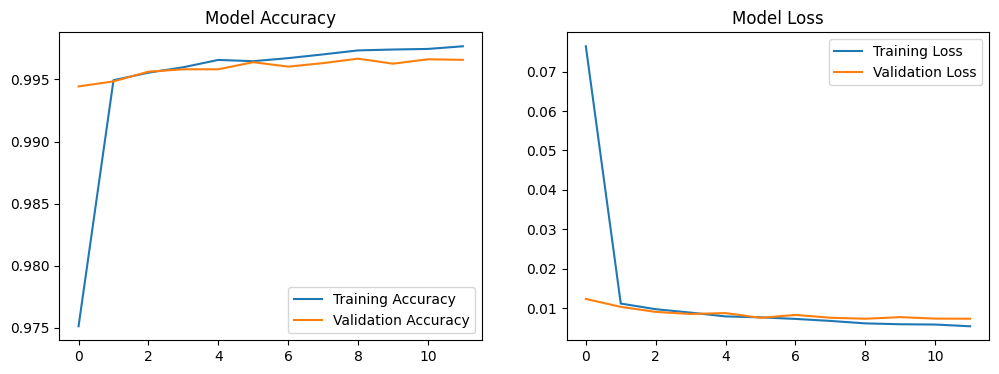

In [20]:
# Train Random Forest with batch processing
rf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))

# Train LSTM with GPU support and batch processing
with strategy.scope():
    lstm_model = Sequential([
        LSTM(64, input_shape=(1, X_train.shape[1]), return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(32),
        BatchNormalization(),
        Dense(2, activation='softmax')
    ])
    lstm_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Prepare data for LSTM
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Train LSTM with early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

history = lstm_model.fit(
    X_train_lstm, y_train_cat,
    epochs=20,  # Reduced epochs
    batch_size=128,  # Increased batch size for GPU
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Evaluate LSTM
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
print("\nLSTM Results:")
print(classification_report(y_test, y_pred_lstm))

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

### MLflow Integration for ML cycles

2025/01/10 17:27:24 INFO mlflow.tracking.fluent: Experiment with name 'insider_threat_detection' does not exist. Creating a new experiment.
2025/01/10 17:27:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52070
           1       0.82      0.83      0.82       530

    accuracy                           1.00     52600
   macro avg       0.91      0.91      0.91     52600
weighted avg       1.00      1.00      1.00     52600

Epoch 1/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9171 - loss: 0.2176 - val_accuracy: 0.9952 - val_loss: 0.0114
Epoch 2/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9949 - loss: 0.0119 - val_accuracy: 0.9954 - val_loss: 0.0096
Epoch 3/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9955 - loss: 0.0101 - val_accuracy: 0.9961 - val_loss: 0.0088
Epoch 4/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9959 - loss: 0.0091 - val_accuracy: 0.9962 - val_loss: 0.0083
Epoch 5/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9963 - loss: 0.0082 - val_accuracy: 0.9962 - val_loss: 0.

2025/01/10 17:30:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/01/10 17:30:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



LSTM Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52070
           1       0.75      0.92      0.83       530

    accuracy                           1.00     52600
   macro avg       0.88      0.96      0.91     52600
weighted avg       1.00      1.00      1.00     52600



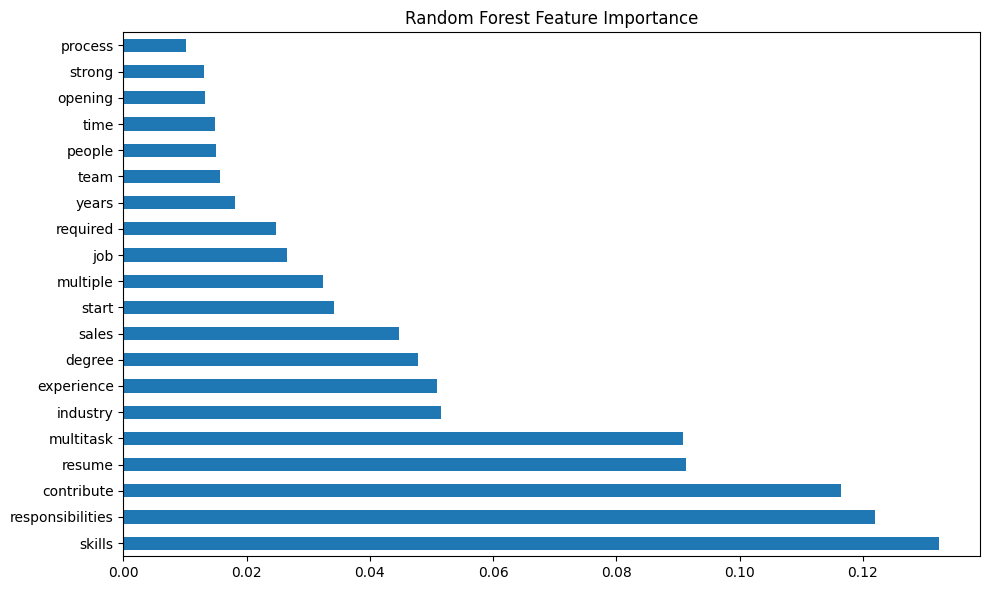

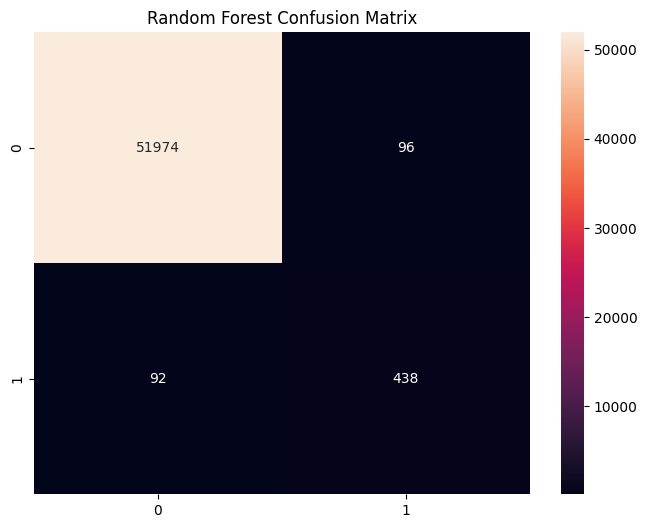

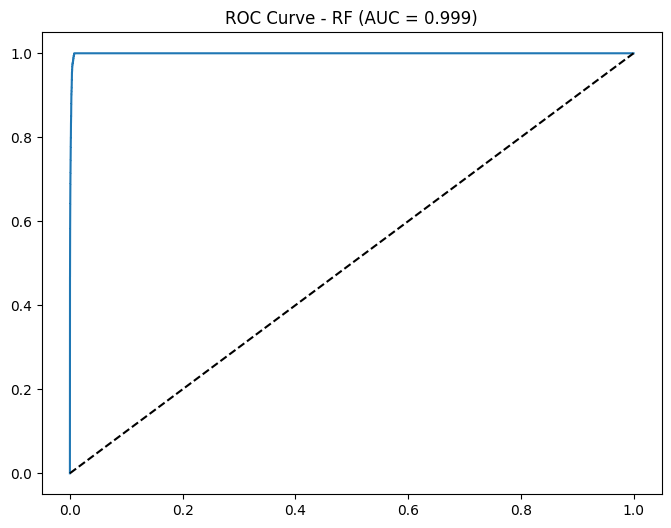

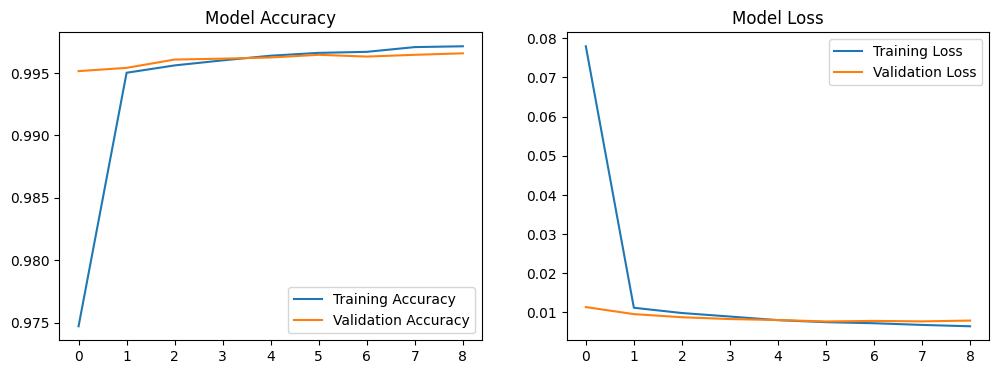

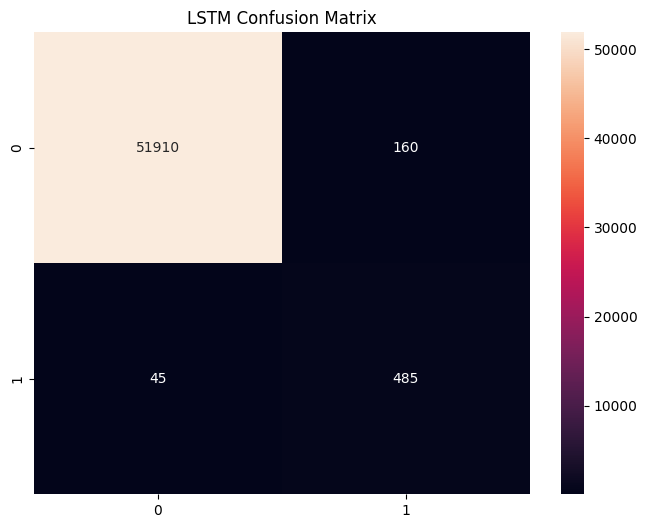

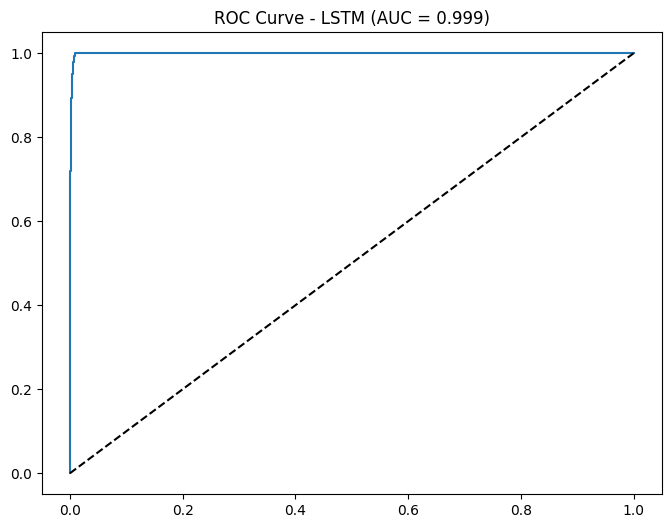

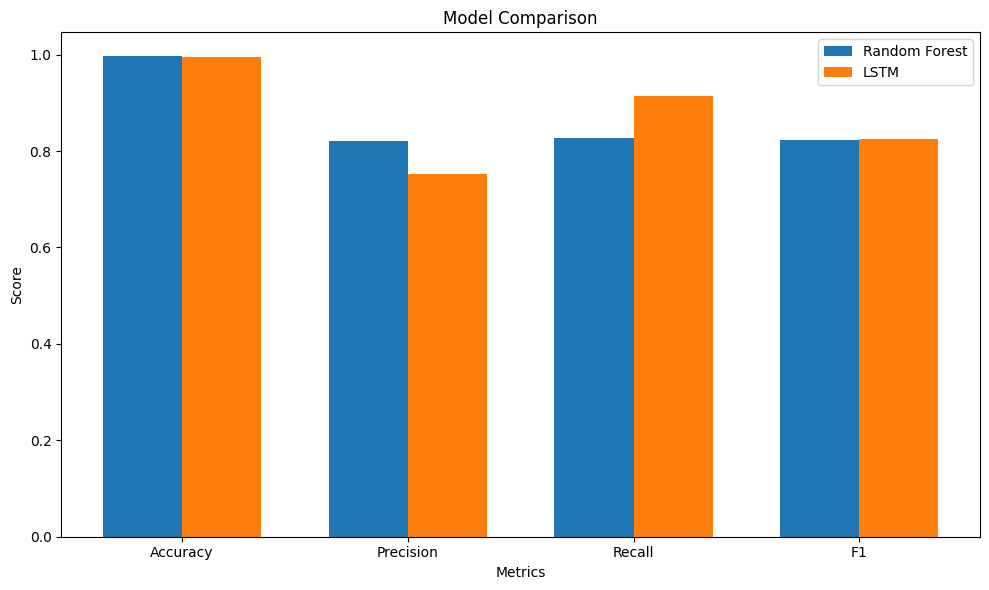

In [21]:
# Set up MLflow
mlflow.set_experiment("insider_threat_detection")

# Train and log models with MLflow
with mlflow.start_run(run_name="model_comparison") as run:
    # Log dataset info
    mlflow.log_param("dataset_size", len(X_train))
    mlflow.log_param("feature_count", X_train.shape[1])

    # Random Forest Training
    with mlflow.start_run(run_name="random_forest", nested=True):
        # Log RF parameters
        rf_params = {
            "n_estimators": 100,
            "max_depth": 10,
            "n_jobs": -1
        }
        mlflow.log_params(rf_params)

        # Train RF
        rf = RandomForestClassifier(**rf_params)
        rf.fit(X_train, y_train)

        # Evaluate RF
        y_pred_rf = rf.predict(X_test)
        y_pred_rf_proba = rf.predict_proba(X_test)[:, 1]

        # Log RF metrics
        rf_metrics = {
            "rf_accuracy": accuracy_score(y_test, y_pred_rf),
            "rf_precision": precision_score(y_test, y_pred_rf),
            "rf_recall": recall_score(y_test, y_pred_rf),
            "rf_f1": f1_score(y_test, y_pred_rf)
        }
        mlflow.log_metrics(rf_metrics)

        # Log RF feature importance plot
        plt.figure(figsize=(10, 6))
        feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns)
        feat_imp.nlargest(20).plot(kind='barh')
        plt.title("Random Forest Feature Importance")
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), "rf_feature_importance.png")

        # Log confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d')
        plt.title("Random Forest Confusion Matrix")
        mlflow.log_figure(plt.gcf(), "rf_confusion_matrix.png")

        # Log ROC curve
        fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_rf, tpr_rf)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"ROC Curve - RF (AUC = {auc(fpr_rf, tpr_rf):.3f})")
        mlflow.log_figure(plt.gcf(), "rf_roc_curve.png")

        # Log RF model
        mlflow.sklearn.log_model(rf, "random_forest_model")

        print("\nRandom Forest Results:")
        print(classification_report(y_test, y_pred_rf))

    # LSTM Training
    with mlflow.start_run(run_name="lstm", nested=True):
        # Log LSTM parameters
        lstm_params = {
            "lstm1_units": 64,
            "lstm2_units": 32,
            "dropout_rate": 0.3,
            "batch_size": 128,
            "epochs": 20
        }
        mlflow.log_params(lstm_params)

        # Build and compile LSTM
        with strategy.scope():
            lstm_model = Sequential([
                LSTM(lstm_params["lstm1_units"],
                     input_shape=(1, X_train.shape[1]),
                     return_sequences=True),
                BatchNormalization(),
                Dropout(lstm_params["dropout_rate"]),
                LSTM(lstm_params["lstm2_units"]),
                BatchNormalization(),
                Dense(2, activation='softmax')
            ])
            lstm_model.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

        # Prepare LSTM data
        X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
        y_train_cat = to_categorical(y_train)
        y_test_cat = to_categorical(y_test)

        # Custom MLflow callback
        class MLflowCallback(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                mlflow.log_metrics(logs, step=epoch)

        # Training callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
            MLflowCallback()
        ]

        # Train LSTM
        history = lstm_model.fit(
            X_train_lstm, y_train_cat,
            epochs=lstm_params["epochs"],
            batch_size=lstm_params["batch_size"],
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

        # Evaluate LSTM
        y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
        y_pred_lstm_proba = lstm_model.predict(X_test_lstm)[:, 1]

        # Log LSTM metrics
        lstm_metrics = {
            "lstm_accuracy": accuracy_score(y_test, y_pred_lstm),
            "lstm_precision": precision_score(y_test, y_pred_lstm),
            "lstm_recall": recall_score(y_test, y_pred_lstm),
            "lstm_f1": f1_score(y_test, y_pred_lstm)
        }
        mlflow.log_metrics(lstm_metrics)

        # Log training history plot
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.legend()
        mlflow.log_figure(plt.gcf(), "lstm_training_history.png")

        # Log LSTM confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, y_pred_lstm), annot=True, fmt='d')
        plt.title("LSTM Confusion Matrix")
        mlflow.log_figure(plt.gcf(), "lstm_confusion_matrix.png")

        # Log LSTM ROC curve
        fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_lstm, tpr_lstm)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"ROC Curve - LSTM (AUC = {auc(fpr_lstm, tpr_lstm):.3f})")
        mlflow.log_figure(plt.gcf(), "lstm_roc_curve.png")

        # Log LSTM model
        mlflow.keras.log_model(lstm_model, "lstm_model")

        print("\nLSTM Results:")
        print(classification_report(y_test, y_pred_lstm))

    # Log model comparison plot
    plt.figure(figsize=(10, 6))
    models = ['Random Forest', 'LSTM']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    rf_scores = [rf_metrics[f"rf_{m.lower()}"] for m in metrics]
    lstm_scores = [lstm_metrics[f"lstm_{m.lower()}"] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, rf_scores, width, label='Random Forest')
    plt.bar(x + width/2, lstm_scores, width, label='LSTM')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), "model_comparison.png")

#### Launch Ngrok and MLflow

In [29]:
!ngrok authtoken "2k18JLz7XU8dn67xDCBKXcrS8aL_7psQCc4GmKqz2MrhumVLh"

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [32]:
import os
from pyngrok import ngrok
import mlflow
import threading
import time
from IPython.display import display, HTML

def start_mlflow_server(mlflow_dir="/content/mlflow"):
    # Start MLflow server in a separate thread
    def run_server():
        os.system(f'mlflow ui --backend-store-uri file:{mlflow_dir} --host 0.0.0.0 --port 5000')

    server_thread = threading.Thread(target=run_server, daemon=True)
    server_thread.start()

    # Wait a bit for the server to start
    time.sleep(5)

    # Create an ngrok tunnel
    public_url = ngrok.connect(5000)
    print(f"\nMLflow UI is now available at: {public_url}")
    print("\nNote: Keep this notebook running to maintain access to the MLflow UI")

    # Create a clickable link
    display(HTML(f'<a href="{public_url}" target="_blank">Click here to open MLflow UI in a new tab</a>'))

# Start the MLflow UI server
start_mlflow_server()


MLflow UI is now available at: NgrokTunnel: "https://be2c-34-124-219-51.ngrok-free.app" -> "http://localhost:5000"

Note: Keep this notebook running to maintain access to the MLflow UI
